In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os, sys
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import pdb

NUM_SAMPLES = 100

In [3]:
x = np.linspace(0,1, num=NUM_SAMPLES)
def gaussian(x, mu, sig, c=1):
    return c*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


## Convolution of local patches of a target

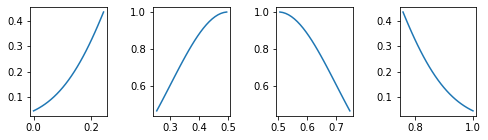

1.5700924586837752e-16

In [4]:
y = gaussian(x,0.2,0.1)

from scipy.spatial import distance

class SymmetricMatrices:
    def __init__(self, x, y, num_filters=4):
        self.num_filters = num_filters
        self.ind_split = np.split(np.arange(len(x)), num_filters)
        self.x_splits = np.split(x, self.num_filters)
        self.y_splits = self._get_splits(y)
        self.Id = self.get_rep(y)
        
    def plot_filters(self):
        fig, axs = plt.subplots(1, self.num_filters, 
                                figsize=(2*self.num_filters, 2))
        fig.subplots_adjust(wspace=0.6)
        for i, (xs,ys) in enumerate(zip(self.x_splits, self.y_splits)):
            axs[i].plot(xs, ys)
        plt.show()
        return 
    
    def _get_splits(self, s):
        s_splits = []
        for ind in self.ind_split:
            s_splits.append(s[ind])
        return np.vstack(s_splits)
    
    def get_rep(self, s):
        s_splits = self._get_splits(s)
        d = distance.pdist(s_splits, distance.correlation)
        return distance.squareform(d)
    
    def distance(self, s):
        M_s = self.get_rep(s)
        return np.linalg.norm(self.Id-M_s,ord='fro')

    
y0 = gaussian(x, 0.5, 0.2, 1)
M  = SymmetricMatrices(x, y0,num_filters = 4)
M.plot_filters()
M.distance(y0*0.1)

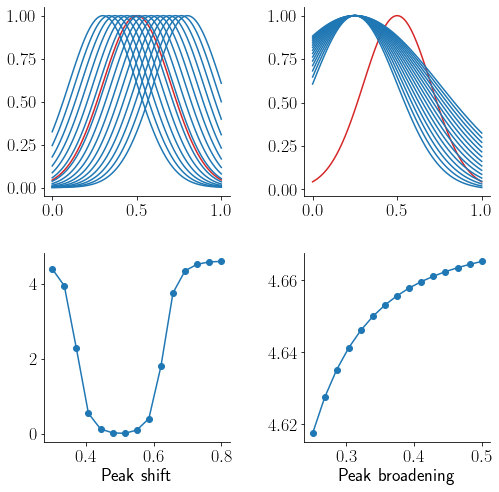

In [10]:
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 18
                    }
                   )

def evaluate_distance(f,y0):
    fig, axs = plt.subplots(2,2,figsize=(4*2, 4*2))
    fig.subplots_adjust(wspace=0.4, hspace=0.3)
    axs[0,0].plot(x,y0, color='tab:red')
    axs[0,1].plot(x,y0, color='tab:red')

    dists = []
    t_mu = np.linspace(0.3,0.8,15)
    for ti in t_mu:
        yi = gaussian(x,ti,0.2)
        axs[0,0].plot(x,yi, color='tab:blue')
        dists.append(f(y0,yi))
    axs[1,0].plot(t_mu, dists, '-o')
    axs[1,0].set_xlabel('Peak shift')

    t_sigma = np.linspace(0.25,0.5,15)
    dists = []
    for ti in t_sigma:
        yi = gaussian(x,0.25,ti)
        axs[0,1].plot(x,yi, color='tab:blue')
        dists.append(f(y0,yi))
    axs[1,1].plot(t_sigma, dists, '-o')
    axs[1,1].set_xlabel('Peak broadening')
    plt.show()
    
y0 = gaussian(x, 0.5, 0.2, 1)
def f(y0,yi):
    manifold = SymmetricMatrices(x, y0, 
                                 num_filters = 4)
    return manifold.distance(yi)

evaluate_distance(f,y0)

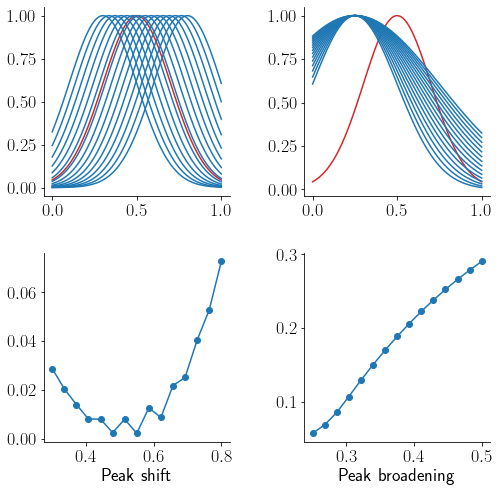

In [11]:
from scipy.stats import wasserstein_distance
evaluate_distance(wasserstein_distance,y0)

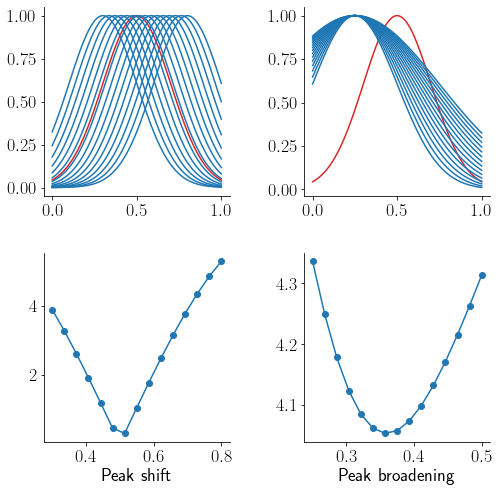

In [12]:
evaluate_distance(distance.euclidean,y0)

## Fourier transform of point clouds in 2D

In [ ]:
class FFT:
    def __init__(self,domain, codomain, dim=32):
        self.data = domain+1j*codomain
        self.dim = dim
        
    def fit(self):
        self.rep = fft(self.data)
        self.rep_hat = np.hstack((self.rep[:self.dim],
                                  self.rep[-(self.dim-1):]))
        self.data_hat = ifft(self.rep_hat)
        
    def transform(self, ind, t):
        rep_t = self.rep.copy()
        for i,ti in zip(ind,t):
            rep_t[i] = rep_t[i]+ti
        data_hat_t = ifft(rep_t)
        
        return data_hat_t
    
    def to_vector(self, d=5):
        vec = np.hstack((self.rep[:d],self.rep[-d:]))
        vec = np.vstack((np.real(vec), np.imag(vec))).flatten()
        
        return vec

    def __len__(self):
        return len(self.rep)*2
    

In [ ]:
y = gaussian(x,0.5,0.1)
rep = FFT(x,y, dim=32)
rep.fit()
fig, ax = plt.subplots()
p0 = rep.transform([0],[0+0j])
ax.plot(np.real(p0), np.imag(p0), label='f')
pt = rep.transform([0,1],[0+0j, 20+1j])
ax.plot(np.real(pt), np.imag(pt), label='f+t')
ax.legend()
plt.show()

In [ ]:
x = np.linspace(0,2, num=NUM_SAMPLES)
y0 = gaussian(x,0.5,0.1)
y1 = gaussian(x,1.5,0.3, c=1.5)
y = 0.5*(y0+y1)
rep = FFT(x,y, dim=64)
rep.fit()
fig, ax = plt.subplots()
p0 = rep.transform([0],[0+0j])
ax.plot(np.real(p0), np.imag(p0), label='f')
pt = rep.transform([1],[10+0j])
ax.plot(np.real(pt), np.imag(pt), label='f+t')
ax.legend()
plt.show()